In [ ]:
# chap07/rnnlm_gen.py
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):      #Rnnlm은 학습된 상태의 모델이어야 한다.
    def generate(self, start_id, skip_ids=None, sample_size=100): #start_id: 최초로 주는 단어의 id, sample_size: 샘플링 하는 단어수, skip_ids: 샘플링 되지 않는 단어 id 리스트
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)   #predict 메서드는 미니배치 처리를 하므로 입력 x는 2차원 배열이어야 한다. [[]] 즉 1x1형태로 성형한다.
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)             #확률 분포에 따라 선택
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids
    
    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):                         # h, c 초기화하는 코드.
        self.lstm_layer.set_state(*state)
        
        
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)


In [1]:
# chap07/generate_text.py
import sys
sys.path.append('..')
from rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
#model.load_params('./Rnnlm2.pkl')              # 이 문장을 생략한다면 아무런 학습도 수행하지 않은 상태에서 문장 생성

# start 문자와 skip 문자 설정
start_word = 'you'  # 첫 단어 
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']  # 샘플링하지 않을 단어
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])           # ' '는 공백 문자입니다. 즉, 각 요소 사이에 공백을 넣어서 문자열로 합치는
txt = txt.replace(' <eos>', '.\n')      #ptb에서 문장을 구분하는데 <eos> 라는 문자열을 사용
print(txt)

you trader photo americans pennzoil dance specialty fallout announce stolen own dictator watson grounds knowledgeable 13-week commission successes country free annuity miniscribe apartments norwood mercury levels clouds breaker cftc feat salaries fda 13th scholar guns present planted rand scott panels postal natural expires agreements permit feb. status import heights picks distance exotic mit prepares entirely political restructured conferees wayne ago dresdner concept nov. consolidated u.s. buick investor calls worth involved neb. he prominent scheduling chamber regulated al ministry syndrome corporation bargaining awful celebration prices lobbied sporadic estimates ima chip participant tapes grand striking only mortgage-backed suggesting nelson countries fatal wants


In [2]:
# chap07/generate_text.py
import sys
sys.path.append('..')
from rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./Rnnlm2.pkl')              # 이 문장을 생략한다면 아무런 학습도 수행하지 않은 상태에서 문장 생성

# start 문자와 skip 문자 설정
start_word = 'you'  # 첫 단어 
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']  # 샘플링하지 않을 단어
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])           # ' '는 공백 문자입니다. 즉, 각 요소 사이에 공백을 넣어서 문자열로 합치는
txt = txt.replace(' <eos>', '.\n')      #ptb에서 문장을 구분하는데 <eos> 라는 문자열을 사용
print(txt)

you 'll be raised.
 some industry observers said mr. andrew certainly is n't profitable into what 's.
 ge 's subcommittee seems to take over a positive price member.
 mr. roman estimates that the former editor will have changed.
 mr. engelken also had been determined if he analyst will provide mr. steinberg.
 a wang spokesman and gm said net income was flat soon because of the harder changes of some long-term use of bad products.
 mr. roman had been looking for one small basketball airline earthquake.
 he never was not not only resolved elsewhere


In [4]:
# chap07/generate_better_text.py
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('./BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:                    # is를 제외한 나머지를 들고온다.
    x = np.array(x).reshape(1, 1)
    model.predict(x)                        #순전파 수행

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you are not looking toward a short-term way.
 most important suitors.
 in the past meeting the critics say regulators ' cooperation a lot of people look through lawyer financier spiegel is going to mount an incorrect deal with the government 's corporate securities.
 the merc said the is the largest their one of the biggest institutional banks that retain the european community tw on the road.
 if the golden bond started in july the french company was trading much than those are interested in.
 but there is n't a sudden market position for the restriction
--------------------------------------------------
the meaning of life is the only way in the conservative states if i believe he is so technical losers in our lives.
 mrs. stone says he has taken a private for a consensus and the airline of one bidder to it became few months the lowest investment in his primary stadiums.
 the justice department should agree about three million pounds a year in its absence because justice will use its

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()       #2개 딕셔너리 리턴턴

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])           #텍스트를 문자 아이디로 변환됨.
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [ ]:
# chap07/seq2seq.py
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):#vocab_size는 0~9의 숫자와 '+'와 '_'를 합쳐 13가지 문자를 사용. word_vec은 문자벡터 차원수, hidden_size는 은닉상태차원수
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')           #Xavier초기화화
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params  # 리스트
        self.grads = self.embed.grads + self.lstm.grads  # 리스트
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]  # 마지막 hidden state

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [ ]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')                   #Xavier 초기화화
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)     #TimeLSTM 계층의 시간방향으로의 기울기는 TimeLSTM클래스의 인스턴스 변수 dh에 저장된다.
        dout = self.embed.backward(dout)
        dh = self.lstm.dh                   
        return dh

    def generate(self, h, start_id, sample_size):       #여기의 h는 Encoder로부터 받는 은닉상태의 h이다.
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

In [ ]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]  #이게 헷갈리면 책의 그림을 보셈
    #decoder_xs는 디코더의 입력 시퀀스를 나타냅니다. 즉, ts에서 마지막 토큰을 제외한 부분(ts[:, :-1])입니다. 이 시퀀스는 디코더가 각 타임스텝에서 예측을 시작하는 데 사용됩니다.
    #decoder_ts는 손실 계산에 사용되는 목표 시퀀스입니다. 즉, ts에서 첫 번째 토큰을 제외한 부분(ts[:, 1:])으로, 디코더의 출력과 비교하여 손실을 계산합니다.
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)        #여기의 h를 decoder에 넣어준다.
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 151 / 351 | 시간 2[s] | 손실 2.00
| 에폭 1 |  반복 301 / 351 | 시간 5[s] | 손실 1.76
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838 
T 864 
X 1000
---
Q 143+93 
T 236 
X 100 
---
검증 정확도 0.180%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.74
| 에폭 2 |  반복 151 / 351 | 시간 2[s] | 손실 1.73
| 에폭 2 |  반복 301 / 351 | 시간 4[s] | 손실 1.70
Q 77+85  
T 162 
X 994 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 700 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 400 
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1544
---
Q 26+838 
T 864 
X 400 
---
Q 143+93 
T 236 
X 400 
---
검증 정확도 0.220%
| 에폭 3 |  반복 1 / 351 | 시간 0[s] | 손실 1.66
| 에폭 3 |  반복 151 / 351 | 시간 2[s] | 손실 1.62
| 에폭 3 |  반복 301 / 351 | 시간 4[s] | 손실 1.53
Q 77+85  
T 162 
X 108 
---
Q 9

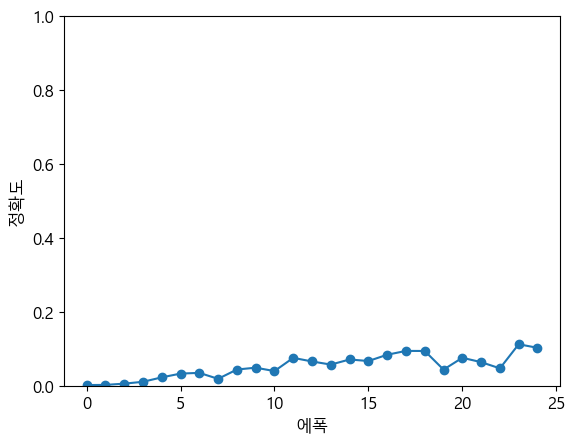

In [1]:
# seq2seq 평가

# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
# from peeky_seq2seq import PeekySeq2seq

####에폭마다 테스트 데이터의 문제 중 몇개를 풀게하여 올바르게 답했는지를 채점. 

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')       #shape은 (데이터수, 시퀀스 길이)
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]                         #x_train[:, ::-1]은 x_train의 모든 행에 대해 각 시퀀스를 뒤집는 작업을 수행.
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

vanilla_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)        #150번의 반복마다 loss출력력

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)        #question은 문제문장(문자id의 배열), correct는 정답(문자 ID의 배열),
                                                                            #verbose는 결과를 출력할지 여부

    acc = float(correct_num) / len(x_test)
    vanilla_acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(vanilla_acc_list))
plt.plot(x, vanilla_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

입력데이터 반전

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 151 / 351 | 시간 3[s] | 손실 2.00
| 에폭 1 |  반복 301 / 351 | 시간 5[s] | 손실 1.76
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838 
T 864 
X 1001
---
Q 143+93 
T 236 
X 703 
---
검증 정확도 0.120%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.73
| 에폭 2 |  반복 151 / 351 | 시간 4[s] | 손실 1.70
| 에폭 2 |  반복 301 / 351 | 시간 8[s] | 손실 1.63
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 690 
---
Q 8+155  
T 163 
X 1000
---
Q 367+55 
T 422 
X 470 
---
Q 600+257
T 857 
X 700 
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1444
---
Q 26+838 
T 864 
X 700 
---
Q 143+93 
T 236 
X 370 
---
검증 정확도 0.400%
| 에폭 3 |  반복 1 / 351 | 시간 0[s] | 손실 1.52
| 에폭 3 |  반복 151 / 351 | 시간 4[s] | 손실 1.47
| 에폭 3 |  반복 301 / 351 | 시간 8[s] | 손실 1.34
Q 77+85  
T 162 
X 158 
---
Q 9

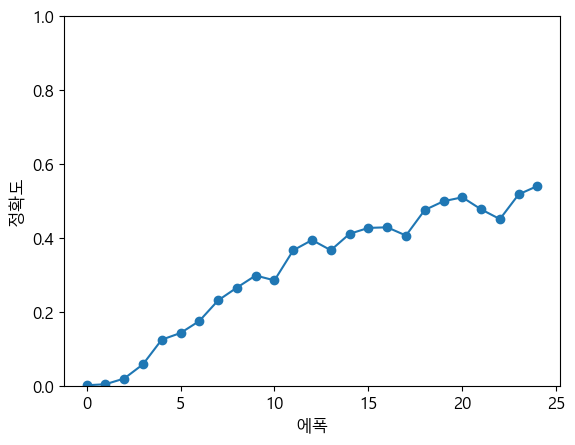

In [2]:
# seq2seq 평가

# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
# from peeky_seq2seq import PeekySeq2seq

####에폭마다 테스트 데이터의 문제 중 몇개를 풀게하여 올바르게 답했는지를 채점. 

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')       #shape은 (데이터수, 시퀀스 길이)
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]                         #x_train[:, ::-1]은 x_train의 모든 행에 대해 각 시퀀스를 뒤집는 작업을 수행.
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

vanilla_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)        #150번의 반복마다 loss출력력

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)        #question은 문제문장(문자id의 배열), correct는 정답(문자 ID의 배열),
                                                                            #verbose는 결과를 출력할지 여부

    acc = float(correct_num) / len(x_test)
    vanilla_acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(vanilla_acc_list))
plt.plot(x, vanilla_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

In [ ]:
exit()

: 

In [ ]:
# chap07/peeky_seq2seq.py
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')           # H+D가 행 왜냐하면 입력에 h도 들어가기 때문.   #he 초기화
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')              # H+H 가 행 왜냐하면 입력에 h도 들어가기 때문.
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)  # h를 시계열만큼 복제(반복하면 shape이 (N*T,H) 여서 reshape을 함)
        out = np.concatenate((hs, out), axis=2)  # concat 후 LSTM으로 입력    out이 N,T,D였음. concatenate을 하면 N,T,H+D

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)  # Affine에도 encoder로부터 온 h와 lstm으로부터 온 h가 들어온다. concat 후 Affine으로 입력. concatenate 후 H+H 개의 열을 갖는다.

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]             #ts로부터 들어간 결과에 대한 역전파. encoder로부터 온 h에 대한 역전파.
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]           #ts로부터 들어간 결과에 대한 역전파. encoder로부터 온 h에 대한 역전파.
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)                 #(lstm에 저장된 dh)와 (dhs의 합)을 합해준다.
        return dh

    def generate(self, h, start_id, sample_size):               #여기의 h는 인코더로부터 나온 h
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]                              #h는 shape이 (1,H) 다.
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))             #forward의 인수를 봐라.
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):                                    #상속받음.
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 151 / 351 | 시간 2[s] | 손실 1.99
| 에폭 1 |  반복 301 / 351 | 시간 5[s] | 손실 1.76
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 26+838 
T 864 
X 102 
---
Q 143+93 
T 236 
X 102 
---
검증 정확도 0.280%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.71
| 에폭 2 |  반복 151 / 351 | 시간 2[s] | 손실 1.70
| 에폭 2 |  반복 301 / 351 | 시간 5[s] | 손실 1.64
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1200
---
Q 582+84 
T 666 
X 690 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 690 
---
Q 600+257
T 857 
X 999 
---
Q 761+292
T 1053
X 1029
---
Q 830+597
T 1427
X 1240
---
Q 26+838 
T 864 
X 792 
---
Q 143+93 
T 236 
X 290 
---
검증 정확도 0.400%
| 에폭 3 |  반복 1 / 351 | 시간 0[s] | 손실 1.58
| 에폭 3 |  반복 151 / 351 | 시간 2[s] | 손실 1.54
| 에폭 3 |  반복 301 / 351 | 시간 5[s] | 손실 1.43
Q 77+85  
T 162 
X 154 
---
Q 9

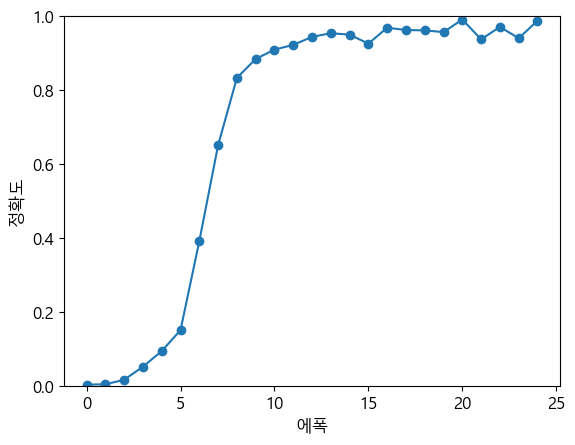

In [3]:
# seq2seq 평가

# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

####에폭마다 테스트 데이터의 문제 중 몇개를 풀게하여 올바르게 답했는지를 채점. 

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')       #shape은 (데이터수, 시퀀스 길이)
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]                         #x_train[:, ::-1]은 x_train의 모든 행에 대해 각 시퀀스를 뒤집는 작업을 수행.
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
#model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

vanilla_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)        #150번의 반복마다 loss출력력

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)        #question은 문제문장(문자id의 배열), correct는 정답(문자 ID의 배열),
                                                                            #verbose는 결과를 출력할지 여부

    acc = float(correct_num) / len(x_test)
    vanilla_acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(vanilla_acc_list))
plt.plot(x, vanilla_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

In [ ]:
exit()

: 

In [1]:
import numpy as np
h = np.array([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 1.0, 1.1, 1.2]])
h_reshaped = h.reshape(1, 1, 4)  # 첫 번째 상태 벡터를 reshape
print(h_reshaped.shape)  # (1, 1, 4)


ValueError: cannot reshape array of size 12 into shape (1,1,4)